In [2]:
import os
import torch
import numpy as np
import nibabel as nib
from tqdm import tqdm
import glob

import torch
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ResizeWithPadOrCrop, NormalizeIntensity
from monai.networks.nets import ViT

In [2]:
# Transform for single image
transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ResizeWithPadOrCrop(spatial_size=(128, 128, 128)),
    NormalizeIntensity()
])

# Load pretrained 3D ViT
# Load pretrained 3D ViT
model = ViT(
    in_channels=1,
    img_size=(128, 128, 128),
    patch_size=(16, 16, 16),
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed_type="none",  
    classification=True,  # to enable CLS token
)

# Remove final classifier head if present
model.classifier = torch.nn.Identity()
model.eval()


ViT(
  (patch_embedding): PatchEmbeddingBlock(
    (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (mlp): MLPBlock(
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (fn): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): SABlock(
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (to_q): Identity()
        (to_k): Identity()
        (to_v): Identity()
        (input_rearrange): Rearrange('b h (qkv l d) -> qkv b l h d', qkv=3, l=12)
        (out_rearrange): Rearrange('b l h d -> b h 

In [5]:
# Paths

# Path to your dataset
image_dir = '/Users/mxvp/Documents/Stanford/thesis/brain/data/TCGA_set2_images'
label_dir = '/Users/mxvp/Documents/Stanford/thesis/brain/data/TCGA_set2_labels'

# Load paths
image_files = sorted(glob.glob(os.path.join(image_dir, '*.nii.gz')))
label_files = sorted(glob.glob(os.path.join(label_dir, '*.nii.gz')))

image_paths = sorted(image_files)  # .nii.gz image files
feature_list = []

# Loop over volumes
for img_path in tqdm(image_paths):
    # Load and preprocess
    img = transform(img_path)
    img = img.unsqueeze(0)  # Add batch dim: [1, 1, D, H, W]
    
    with torch.no_grad():
        model_output = model(img)  # This returns a tuple
        
        # Access the correct output
        # For ViT with classification head removed, the CLS token is likely the first element
        cls_token = model_output[0]  # Try this first
        
        # Alternatively, if the above doesn't work, inspect model_output to see its structure
        # print(type(model_output), len(model_output))
    
    feature_list.append(cls_token.squeeze(0).cpu().numpy())  # remove batch dim and convert to numpy

100%|██████████| 159/159 [00:55<00:00,  2.87it/s]


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap



# Assuming: feature_list = [array([768]), array([768]), ..., array([768])]
features = np.stack(feature_list)  # shape: [N_samples, 768]
print("Feature shape:", features.shape)



Feature shape: (159, 2)


In [13]:
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(features)

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_result = reducer.fit_transform(features)


/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


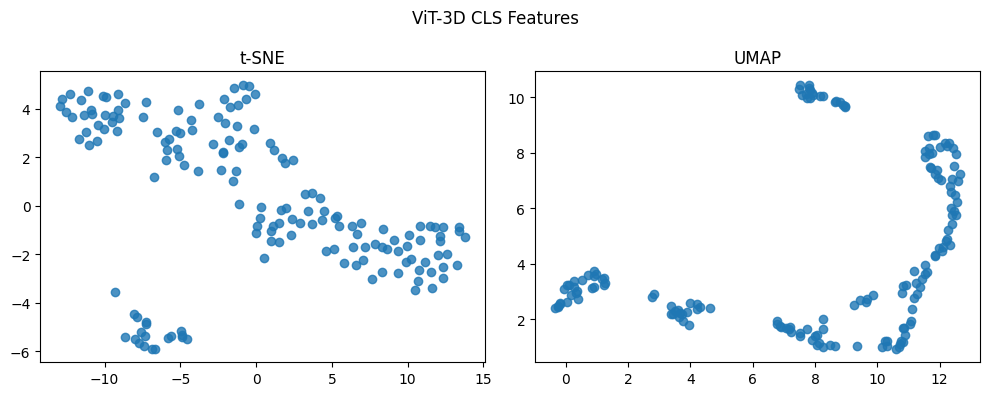

In [14]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.8)
plt.title("t-SNE")

plt.subplot(1, 2, 2)
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.8)
plt.title("UMAP")

plt.suptitle("ViT-3D CLS Features")
plt.tight_layout()
plt.show()
